# Methodology provided by:
https://www.analyticsvidhya.com/blog/2021/10/machine-learning-for-stock-market-prediction-with-step-by-step-implementation/



#### Stock market predictions are difficult for multiple reasons:
#### Market Volatility, numerous dependent and independent influences

#### Machine learning is a start to advancing Stock Market predictions and data analysis

# Long Short-Term Memory (LSTM)

LSTM is a form of an artificial Recurrent Neural Network (RNN) architecture. Its ability to handle single data points, such as pictures, as well as data sequences (voice and video) makes it a versatile architecture with opportunities for multiple field applications. While LSTM's and their structure are difficult to understand (beyond the scope of this class) they have main strengths that should motivate further investigation: Overcoming of exploding and vanishing gradients, can properly handle larger discreet time steps. 



In this notebook, we look at an example of predicting stock market closing prices using a relatively simple outline for how
to produce your own code! Below you'll see all imports required for this notebook to run.

In [1]:
#Importing the Libraries
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

### CSV file obtained from:
https://finance.yahoo.com/quote/MSFT/history/?guccounter=1&guce_referrer=aHR0cHM6Ly93d3cuZ29vZ2xlLmNvbS8&guce_referrer_sig=AQAAAKl4kTVoEauTlpQdZPgvlNDjvHBgrFgr-1w_Ws8DOsEkMfOU5Y6eU2E9lWQwsRDojwyH_ZXBTf9QnVnWx-I18NTLD18-uDnb_IQOcOpz97Mt_4QDORCjZQpVn_oIUeBSrvXaIhFuEjN9VlAw5IGPAvVBdlOPfk2_LyLcHhY2PyVK

In [17]:
# Dataset
path = '/mnt/c/Users/user/Desktop/Math_Final/MSFT.csv'
df = pd.read_csv(path, na_values=['null'], index_col='Date', parse_dates=True, infer_datetime_format=True)


In [18]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.061378,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.063570,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.064667,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.063022,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061926,47894400


# Check shape and presence of null values within dataframe

In [3]:
# Print the shape of Dataframe and Check for Null Values
print("Datafram shape: ", df.shape)
print("Null Value Present: ", df.isnull().values.any())

Datafram shape:  (9007, 6)
Null Value Present:  False


In [4]:
df['Adj Close']

Date
1986-03-13      0.061378
1986-03-14      0.063570
1986-03-17      0.064667
1986-03-18      0.063022
1986-03-19      0.061926
                 ...    
2021-11-29    336.630005
2021-11-30    330.589996
2021-12-01    330.079987
2021-12-02    329.489990
2021-12-03    323.010010
Name: Adj Close, Length: 9007, dtype: float64

# Visualization of Closing Cost values

<AxesSubplot:xlabel='Date', ylabel='Adjust Closing Price (USD)'>

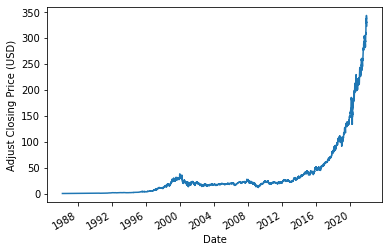

In [5]:
# Plot the Close Value

df['Adj Close'].plot(ylabel='Adjust Closing Price (USD)')

# Variable Setting

Now, we want to establish our two main variables: the independent and the dependent. Since the objective of our program is to predict the closing price for the particular company, the dependent variable is "Adjusted Closing Cost" or 'Adj Close' in this dataframe. We have 4 independent variables that we are assuming exclusively affect our dependent: 'Open', 'High', 'Low', and 'Volume'.

In [6]:
# Set Target Variable
output_var = pd.DataFrame(df['Adj Close'])
# Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

# Scaling
Here, we are normalizing (or 'scaling') our data to [0,1], significantly reducing computation cost and improving performance. the `MinMaxScalar()` function from SciKitLearn is being used.

In [7]:
# Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
1986-03-13,0.000000,0.000027,0.000000,1.000000
1986-03-14,0.000025,0.000030,0.000025,0.297096
1986-03-17,0.000035,0.000032,0.000036,0.127119
1986-03-18,0.000040,0.000032,0.000030,0.063588
1986-03-19,0.000033,0.000025,0.000025,0.044285


# Training and Testing Sets

We want to split our dataset into training and testing sets. `TimeSeriesSplit()` from SKLearn is being used to create our split of 10% testing, 90% training. 

In [8]:
# Splitting to Training and Test sets
timesplit = TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
    X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
    y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index):(len(train_index)+len(train_index))].values.ravel()
    
    

# Data Processing

LSTM requires our data to be re-formatted into the following form: (# of Samples, 1, # of features)

In [9]:
# Process data for LSTM
trainX = np.array(X_train)
testX = np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

# Model Building

We are building a Sequential Keras model with 3 layers: Input Layer, LSTM Layer, and a Dense Layer. Our model is optimized using Adam and the loss function is computed via Mean Squared Error. 

In [19]:
# Building LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
#plot_model(lstm, show_shapes=True, show_layer_names=True)

In [11]:
# Model Training
history = lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
1024/1024 [==============================] - 1s 666us/step - loss: 80.4054
Epoch 2/100
1024/1024 [==============================] - 1s 650us/step - loss: 196.0678
Epoch 3/100
1024/1024 [==============================] - 1s 644us/step - loss: 138.1342
Epoch 4/100
1024/1024 [==============================] - 1s 646us/step - loss: 82.3584
Epoch 5/100
1024/1024 [==============================] - 1s 644us/step - loss: 43.9612
Epoch 6/100
1024/1024 [==============================] - 1s 639us/step - loss: 19.3877
Epoch 7/100
1024/1024 [==============================] - 1s 645us/step - loss: 7.5580
Epoch 8/100
1024/1024 [==============================] - 1s 636us/step - loss: 3.5890
Epoch 9/100
1024/1024 [==============================] - 1s 646us/step - loss: 2.3581
Epoch 10/100
1024/1024 [==============================] - 1s 645us/step - loss: 1.8006
Epoch 11/100
1024/1024 [==============================] - 1s 648us/step - loss: 1.4778
Epoch 12/100
1024/1024 [====================

# Visualization of Loss Over Epochs

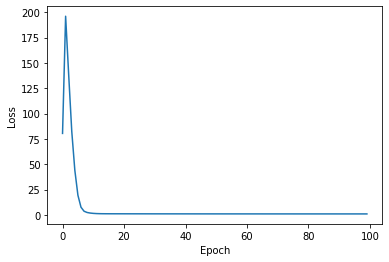

In [12]:
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# Create Predictions Using LSTM

In [13]:
# LSTM Prediction
y_pred = lstm.predict(X_test)

# Visualization of Predictions vs. True Values

Let us see how our LSTM model performs relative to the true values of Closing Costs. 

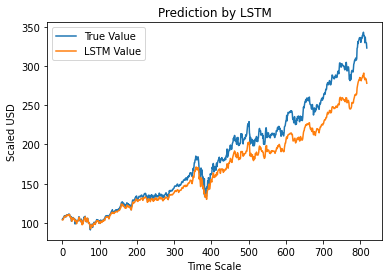

In [14]:
# Predicted vs True Adj Close Value using LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

# Analysis

Notice that the LSTM model has prediction some temporal phenomenology, but underestimates our closing costs. With hyperparameter tuning and the addition of more LSTM layers to our model, the predictions can become more accurate. 

# Error within Predictions

Here, we are visualizing the error between our predicted and true values. The error is computed by:

## $\frac{|TrueValue - PredictedValue|}{True Value} \times 100$

In [15]:
def error(set1, set2):
    
    y = set1
    y_hat = set2
    error = np.zeros(len(y))
    for i in range(len(y)):
        error[i] = (np.abs(y[i]-y_hat[i])/y[i])*100
    return (error)

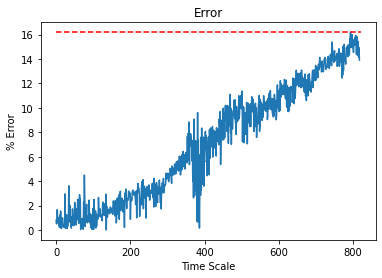

In [22]:
plt.plot(error(y_test, y_pred))
plt.plot([0,820], [np.max(error(y_test, y_pred)),np.max(error(y_test, y_pred))], '--', color='red')
plt.xlabel('Time Scale')
plt.ylabel('% Error')
plt.title('Error')
plt.show()